# Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Create output directory for everything we will do here

In [2]:
str_dirname_output = './output'

try:
    os.mkdir(str_dirname_output)
except:
    pass

# Import data

In [3]:
# import train and valid and get list of cols
df_train = pd.read_csv('./input/train.csv')
df_valid = pd.read_csv('./input/test.csv')

# isolate test IDs
arr_ids_test = df_valid['SK_ID_CURR'].values # -- 48744 rows

# get columns list
list_cols = list(df_train.columns)
list_cols_notarget = list(df_valid.columns)
list_cols

# get cols without date, target, ID
list_ids = ['TARGET', 'SK_ID_CURR', 'APP_DATE', 'FLAG_MOBIL'] # we learn about flag mobile from further down
list_cols_use = [col for col in list_cols if col not in list_ids]
list_cols_use

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG

In [4]:
len(list_cols_use)

119

In [5]:
# get cols numeric and cols non-numeric
list_cols_numeric = df_train[list_cols_use].select_dtypes(include=['number']).columns.tolist()
list_cols_nonnumeric = df_train[list_cols_use].select_dtypes(exclude=['number']).columns.tolist()

In [6]:
# get shape
print(df_train.shape)
print(df_valid.shape)

(125000, 123)
(48744, 122)


# Exploratory Data Analysis

#### Get general data info

In [7]:
# get mean target
flt_mean_target =  np.mean(df_train['TARGET'])

# get date min/max for train
train_date_min =  str(np.min(df_train['APP_DATE']))
train_date_max =  str(np.max(df_train['APP_DATE']))

# get date min/max for valid
valid_date_min =  str(np.min(df_valid['APP_DATE']))
valid_date_max =  str(np.max(df_valid['APP_DATE']))

# get prop missing
prop_missing_train = (np.sum(df_train.isnull().sum())) / (df_train.size)
prop_missing_valid = (np.sum(df_valid.isnull().sum())) / (df_valid.size)


dict_info = {
    'target_mean': flt_mean_target,
    'min_train_date': train_date_min,
    'max_train_date': train_date_max,
    'min_valid_date': valid_date_min, 
    'max_valid_date': valid_date_max,
    'proportion_na_train': prop_missing_train,
    'proportion_na_valid': prop_missing_valid,
}

pprint(dict_info, sort_dicts=False)

{'target_mean': 0.0806,
 'min_train_date': '2016-01-01',
 'max_train_date': '2017-01-01',
 'min_valid_date': '2018-01-01',
 'max_valid_date': '2018-06-01',
 'proportion_na_train': 0.24216767479674797,
 'proportion_na_valid': 0.23703716035332134}


#### Get descriptions by column

In [8]:
# get descriptives for each column
def get_descriptives_by_column(df):
	# get descriptives
	list_dict_row = []
	for col in tqdm (df.columns):
		# save as series
		ser_col = df[col]
		# get proportion nan
		flt_prop_na = ser_col.isnull().mean()
		if flt_prop_na == 1.0:
			# create row
			dict_row = {
				'feature': col,
				'dtype': np.nan,
				'propna': flt_prop_na,
				'min': np.nan,
				'max': np.nan,
				'range': np.nan,
				'std': np.nan,
				'mean': np.nan,
				'median': np.nan,
				'mode': np.nan,
				'n_unique': 0,
				'prop_unique': 0,
				'prop_negative': np.nan,
				'prop_min': np.nan,
				'prop_max': np.nan,
				'prop_zero': np.nan,
			}
			# append
			list_dict_row.append(dict_row)
			# skip the rest of the iteration
			continue
		# get data type
		str_dtype = ser_col.dtype
		# if value
		if str_dtype in ['float64', 'int64']:
			val_min, val_max, val_mean, val_std, val_median = ser_col.min(), ser_col.max(), ser_col.mean(), ser_col.std(), ser_col.median()
			val_range = val_max - val_min
			val_mode, int_n_unique = ser_col.mode().iloc[0], ser_col.nunique()
			flt_prop_unique = int_n_unique / len(ser_col.dropna())
			flt_prop_negative = len(ser_col[ser_col<0]) / len(ser_col.dropna())
			flt_prop_min = len(ser_col[ser_col==val_min]) / len(ser_col.dropna())
			flt_prop_max = len(ser_col[ser_col==val_max]) / len(ser_col.dropna())
			flt_prop_zero = len(ser_col[ser_col==0]) / len(ser_col.dropna())
		# if object
		if str_dtype == 'O':
			val_min, val_max, val_std, val_mean, val_median = np.nan, np.nan, np.nan, np.nan, np.nan
			val_range = np.nan
			val_mode, int_n_unique = ser_col.mode().iloc[0], ser_col.nunique()
			flt_prop_unique = int_n_unique / len(ser_col.dropna())
			flt_prop_negative = np.nan 
			flt_prop_min = np.nan
			flt_prop_max = np.nan
			flt_prop_zero = np.nan
		# if dtm
		if str_dtype == 'datetime64[ns]':
			val_min, val_max, val_mean, val_std, val_median = ser_col.min(), ser_col.max(), ser_col.mean(), np.nan, np.nan
			val_range = val_max - val_min
			val_mode, int_n_unique = ser_col.mode().iloc[0], ser_col.nunique()
			flt_prop_unique = int_n_unique / len(ser_col.dropna())
			flt_prop_negative = np.nan 
			flt_prop_min = len(ser_col[ser_col==val_min]) / len(ser_col.dropna())
			flt_prop_max = len(ser_col[ser_col==val_max]) / len(ser_col.dropna())
			flt_prop_zero = np.nan
		# create row
		dict_row = {
			'feature': col,
			'dtype': str_dtype,
			'propna': flt_prop_na,
			'min': val_min,
			'max': val_max,
			'range': val_range,
			'std': val_std,
			'mean': val_mean,
			'median': val_median,
			'mode': val_mode,
			'n_unique': int_n_unique,
			'prop_unique': flt_prop_unique,
			'prop_negative': flt_prop_negative,
			'prop_min': flt_prop_min,
			'prop_max': flt_prop_max,
			'prop_zero': flt_prop_zero,
		}
		# append
		list_dict_row.append(dict_row)
	# make df
	df_descriptives = pd.DataFrame(list_dict_row)
	# order cols
	df_descriptives.columns = [
		'feature',
		'dtype',
		'propna',
		'min',
		'max',
		'range',
		'std',
		'mean',
		'median',
		'mode',
		'n_unique',
		'prop_unique',
		'prop_negative',
		'prop_min',
		'prop_max',
		'prop_zero',
	]
	df_descriptives.sort_values(by='propna', ascending=False, inplace=True)
	# return
	return df_descriptives

df_train_desc = get_descriptives_by_column(df=df_train)
df_valid_desc = get_descriptives_by_column(df=df_valid)

100%|███████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 342.32it/s]


In [9]:
df_train_desc

,feature,dtype,propna,min,max,range,std,mean,median,mode,n_unique,prop_unique,prop_negative,prop_min,prop_max,prop_zero
48,COMMONAREA_AVG,float64,0.699624,0.0,1.0,1.0,0.076619,0.044599,0.0210,0.0,2621,0.069806,0.0,0.090926,0.001039,0.090926
76,COMMONAREA_MEDI,float64,0.699624,0.0,1.0,1.0,0.076981,0.044630,0.0208,0.0,2632,0.070099,0.0,0.093536,0.001039,0.093536
62,COMMONAREA_MODE,float64,0.699624,0.0,1.0,1.0,0.075316,0.042559,0.0190,0.0,2559,0.068155,0.0,0.104562,0.001039,0.104562
84,NONLIVINGAPARTMENTS_MEDI,float64,0.695400,0.0,1.0,1.0,0.045099,0.008315,0.0000,0.0,163,0.004281,0.0,0.600236,0.000840,0.600236
56,NONLIVINGAPARTMENTS_AVG,float64,0.695400,0.0,1.0,1.0,0.045384,0.008457,0.0000,0.0,296,0.007774,0.0,0.583926,0.000840,0.583926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,CNT_FAM_MEMBERS,int64,0.000000,1.0,20.0,19.0,0.910911,2.151024,2.0000,2,13,0.000104,0.0,0.220936,0.000008,0.000000
27,FLAG_EMAIL,int64,0.000000,0.0,1.0,1.0,0.230293,0.056192,0.0000,0,2,0.000016,0.0,0.943808,0.056192,0.943808
26,FLAG_PHONE,int64,0.000000,0.0,1.0,1.0,0.450029,0.282112,0.0000,0,2,0.000016,0.0,0.717888,0.282112,0.717888
25,FLAG_CONT_MOBILE,int64,0.000000,0.0,1.0,1.0,0.043226,0.998128,1.0000,1,2,0.000016,0.0,0.001872,0.998128,0.001872


In [10]:
df_valid_desc

,feature,dtype,propna,min,max,range,std,mean,median,mode,n_unique,prop_unique,prop_negative,prop_min,prop_max,prop_zero
61,COMMONAREA_MODE,float64,0.687161,0.0,1.0,1.0,0.081169,0.045223,0.0203,0.0,2001,0.131222,0.0,0.105187,0.001246,0.105187
47,COMMONAREA_AVG,float64,0.687161,0.0,1.0,1.0,0.082868,0.047624,0.0227,0.0,2042,0.133910,0.0,0.090039,0.001312,0.090039
75,COMMONAREA_MEDI,float64,0.687161,0.0,1.0,1.0,0.082892,0.047420,0.0223,0.0,2034,0.133386,0.0,0.093449,0.001246,0.093449
83,NONLIVINGAPARTMENTS_MEDI,float64,0.684125,0.0,1.0,1.0,0.048148,0.008979,0.0000,0.0,134,0.008703,0.0,0.592128,0.000844,0.592128
69,NONLIVINGAPARTMENTS_MODE,float64,0.684125,0.0,1.0,1.0,0.046657,0.008358,0.0000,0.0,106,0.006884,0.0,0.625966,0.000779,0.625966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,CNT_FAM_MEMBERS,int64,0.000000,1.0,21.0,20.0,0.890423,2.146767,2.0000,2,12,0.000246,0.0,0.210303,0.000021,0.000000
26,FLAG_EMAIL,int64,0.000000,0.0,1.0,1.0,0.369046,0.162646,0.0000,0,2,0.000041,0.0,0.837354,0.162646,0.837354
25,FLAG_PHONE,int64,0.000000,0.0,1.0,1.0,0.440337,0.263130,0.0000,0,2,0.000041,0.0,0.736870,0.263130,0.736870
24,FLAG_CONT_MOBILE,int64,0.000000,0.0,1.0,1.0,0.039971,0.998400,1.0000,1,2,0.000041,0.0,0.001600,0.998400,0.001600


#### Get nan info

In [11]:
# get nan analysis for columns
def get_prop_nan(df):
    dict_nans = {}
    # get number of rows
    int_n_rows = len(df)
    # iter through the columns in df
    for col in df.columns:
        # count # of nanas
        nan_count = df[col].isna().sum()
        # get prop
        nan_proportion = nan_count / int_n_rows
        # get col name
        dict_nans[col] = nan_proportion
    # # show
    # pprint(dict_nans)
    # return
    return dict_nans

# get nan analysis for columns in train
dict_nans_train = get_prop_nan(df=df_train[list_cols_notarget])
# get nan analysis for columns in valid
dict_nans_valid = get_prop_nan(df=df_valid[list_cols_notarget])

# combine into df to compare nans
nan_sers_train = pd.Series(dict_nans_train, name='train_nans')
nan_sers_valid = pd.Series(dict_nans_valid, name='valid_nans')
df_prop_nans = pd.concat([nan_sers_train, nan_sers_valid], axis=1).reset_index()
df_prop_nans.columns = ['feature', 'train_nans', 'valid_nans']

# check features diff
df_prop_nans['diff'] = abs(df_prop_nans['train_nans'] - df_prop_nans['valid_nans'])
df_prop_nans.sort_values(by='diff', ascending=False)

,feature,train_nans,valid_nans,diff
40,EXT_SOURCE_1,0.563824,0.421221,0.142603
6,AMT_INCOME_TOTAL,0.000000,0.106393,0.106393
42,EXT_SOURCE_3,0.198816,0.177827,0.020989
49,ENTRANCES_AVG,0.503504,0.483731,0.019773
77,ENTRANCES_MEDI,0.503504,0.483731,0.019773
...,...,...,...,...
35,LIVE_REGION_NOT_WORK_REGION,0.000000,0.000000,0.000000
36,REG_CITY_NOT_LIVE_CITY,0.000000,0.000000,0.000000
37,REG_CITY_NOT_WORK_CITY,0.000000,0.000000,0.000000
38,LIVE_CITY_NOT_WORK_CITY,0.000000,0.000000,0.000000


In [12]:
# get cols where missing in valid but not train
list_missing_val = df_prop_nans[(df_prop_nans['train_nans'] == 0) & (df_prop_nans['valid_nans'] != 0)]['feature'].tolist()

# get cols missin in train but not valid
list_missing_train = df_prop_nans[(df_prop_nans['train_nans'] != 0) & (df_prop_nans['valid_nans'] == 0)]['feature'].tolist()

# show
list_missing_train,list_missing_val

(['AMT_GOODS_PRICE'], ['AMT_INCOME_TOTAL'])

#### Get target info

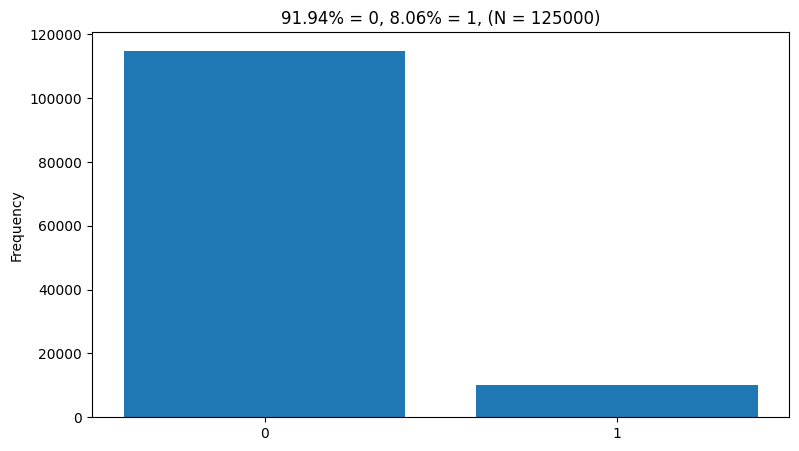

In [13]:
# plot target -- HIGH TARGET IMBALANCE!!!
def plot_target(ser_target):
	# get the total positive
	int_tot_pos = np.sum(ser_target)
	# get total
	int_total = len(ser_target)
	# get the toeal negative
	int_tot_neg = int_total - int_tot_pos
	# get pct negative class
	flt_pct_negative = (int_tot_neg / int_total) * 100
	# get pct positive class
	flt_pct_positive = (int_tot_pos / int_total) * 100
	# create axis
	fig, ax = plt.subplots(figsize=(9,5))
	# title
	ax.set_title(f'{flt_pct_negative:0.4}% = 0, {flt_pct_positive:0.4}% = 1, (N = {int_total})')
	# frequency bar plot
	ax.bar([0, 1], [int_tot_neg, int_tot_pos])
	# ylabel
	ax.set_ylabel('Frequency')
	# xticks
	ax.set_xticks([0, 1])
	# xtick labels
	ax.set_xticklabels(['0','1'])
	# show
	plt.show()

plot_target(ser_target=df_train['TARGET'])

#### Check cols for no variance

In [14]:
# check for columns in train with no variance -- this is getting dropped later

list_no_var = []
# iterate through columns in df
for col in df_train.columns:
	# get the series
	series_ = df_train[col]
	# drop na
	series_.dropna(inplace=True)
	# get count unique
	count_unique = series_.nunique()
	# if count_unique == 1
	if count_unique == 1:
		# append to list
		list_no_var.append(col)

list_no_var

['FLAG_MOBIL']

#### Check cols for amt and day features

In [15]:
# check for columns with AMT in name and DAY in column, maybe to be used in feature engineering later????
list_cols_amt = [col for col in list_cols if 'AMT' in col]
list_cols_day = [col for col in list_cols if 'DAY' in col]
list_cols_count = [col for col in list_cols if 'CNT' in col]
list_cols_day, list_cols_amt, list_cols_count

(['DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'WEEKDAY_APPR_PROCESS_START',
  'DAYS_LAST_PHONE_CHANGE',
  'AMT_REQ_CREDIT_BUREAU_DAY'],
 ['AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'AMT_REQ_CREDIT_BUREAU_HOUR',
  'AMT_REQ_CREDIT_BUREAU_DAY',
  'AMT_REQ_CREDIT_BUREAU_WEEK',
  'AMT_REQ_CREDIT_BUREAU_MON',
  'AMT_REQ_CREDIT_BUREAU_QRT',
  'AMT_REQ_CREDIT_BUREAU_YEAR'],
 ['CNT_CHILDREN',
  'CNT_FAM_MEMBERS',
  'OBS_30_CNT_SOCIAL_CIRCLE',
  'DEF_30_CNT_SOCIAL_CIRCLE',
  'OBS_60_CNT_SOCIAL_CIRCLE',
  'DEF_60_CNT_SOCIAL_CIRCLE'])

#### Check distributions of all numeric features in the data - nothing looks too insane

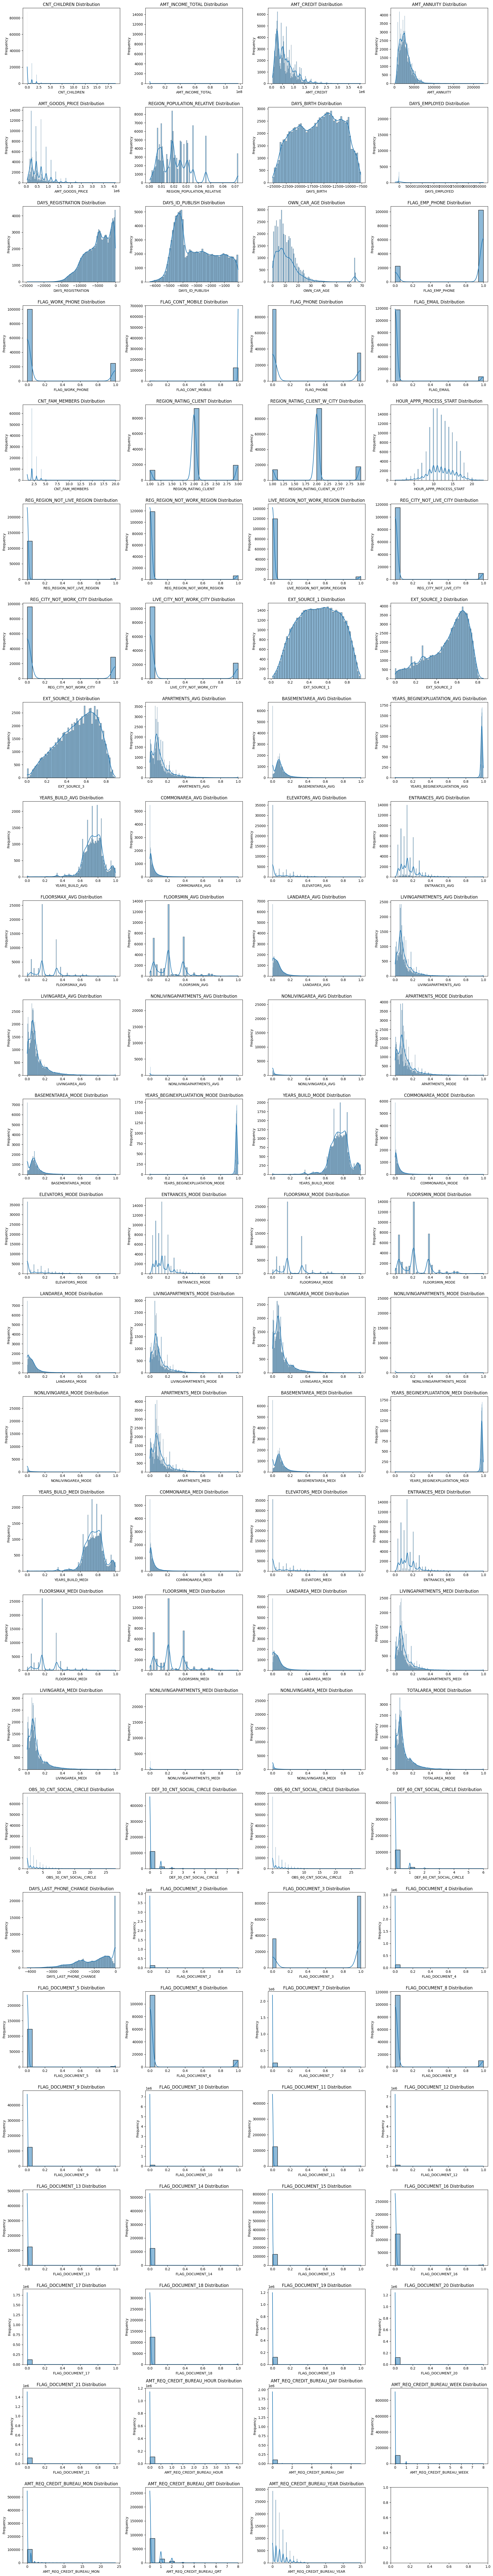

In [16]:
# plot distributions
def plot_numeric_distribution(df):
    # get numeric cols
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    num_cols = len(numeric_cols.columns)
    # get how many rows we need for subplot
    num_rows = (num_cols + 2) // 4
    # plot it
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 4*num_rows))
    axes = axes.flatten()
    # iterate through cols
    for i, col in enumerate(numeric_cols.columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(col + ' Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_numeric_distribution(df_train[list_cols_use])

#### Check nonnumeric cols for binary features to convert to 0/1

In [17]:
list_cols_binary = [col for col in list_cols_nonnumeric if (len(df_train[col].value_counts()) == 2)]
# list_cols_binary.remove('EMERGENCYSTATE_MODE')
list_cols_binary # we will use this to encode binary

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

#### Here we discover the representation of gender in train is different than test, 'XNA' is the culprit, will write a loop that takes care of this for other columns as well

In [18]:
list_cols_binary_valid = [col for col in list_cols_nonnumeric if (len(df_valid[col].value_counts()) == 2)]
# list_cols_binary_valid.remove('EMERGENCYSTATE_MODE')
list_cols_binary_valid # WE WILL USE THIS INSTEAD 

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [19]:
# iterate col in list_cols_nonnumeric
for col in list_cols_nonnumeric:
    # find unique values in the training set but not in the test set
    values_to_remove = set(df_train[col].unique()) - set(df_valid[col].unique())
    
    # remove rows with these values from the training set
    df_train = df_train[~df_train[col].isin(values_to_remove)]

df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APP_DATE
0,434344,0,Cash loans,F,N,N,0,270000.0,675000.0,49117.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,2016-04-10
1,400355,0,Cash loans,M,Y,Y,1,157500.0,986553.0,31824.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2016-09-10
2,425573,0,Cash loans,M,Y,Y,0,315000.0,319500.0,34537.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2016-08-27
3,357901,0,Cash loans,F,N,Y,0,108000.0,797868.0,23328.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-25
4,106835,0,Cash loans,F,N,Y,1,157500.0,900000.0,29164.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124995,377212,0,Cash loans,M,Y,Y,0,112500.0,835380.0,35523.0,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,2016-09-29
124996,456126,0,Cash loans,F,Y,Y,0,202500.0,544500.0,15921.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,8.0,2016-05-05
124997,395436,0,Cash loans,F,N,Y,0,45000.0,76410.0,4513.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-22
124998,323045,0,Cash loans,M,Y,N,0,135000.0,456273.0,17037.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2016-06-24


# Preprocessing - do preprocessing / feature engineering from insights derived above - in hindsight should probably take gender out because sexism

#### Drop FLAG_MOBIL (no variance in train) -- moved to very top DATA IMPORT SECTION

#### Take care of binary cat features

In [20]:
# make these cols into binary 0/1
list_cols_binary_valid

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [21]:
print(df_train.NAME_CONTRACT_TYPE.value_counts()) # Cash loans / Revolving loans 
print(df_train.CODE_GENDER.value_counts()) # F / M
print(df_train.FLAG_OWN_CAR.value_counts()) # Y / N
print(df_train.FLAG_OWN_REALTY.value_counts()) # Y / N

NAME_CONTRACT_TYPE
Cash loans         113097
Revolving loans     11900
Name: count, dtype: int64
CODE_GENDER
F    82599
M    42398
Name: count, dtype: int64
FLAG_OWN_CAR
N    82687
Y    42310
Name: count, dtype: int64
FLAG_OWN_REALTY
Y    86542
N    38455
Name: count, dtype: int64


In [22]:
# write function to quickly transform both train and test
def binary_encode_columns(df, columns, bin_one):
    for col, one in zip(columns, bin_one):
        df[col] = [1 if val == one else 0 for val in df[col]]
    return df

columns_to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
bin_one_labels = ['Cash loans', 'F', 'Y', 'Y']

# run func
df_train = binary_encode_columns(df=df_train,
                                 columns=columns_to_encode,
                                 bin_one=bin_one_labels)

df_valid = binary_encode_columns(df=df_valid,
                                 columns=columns_to_encode,
                                 bin_one=bin_one_labels)

In [23]:
df_train.shape, df_valid.shape # checks out

((124997, 123), (48744, 122))

#### Impute

In [24]:
# write function to impute for missing numberic columns
def imputer(df, list_cols_numeric):
    # iter and impute
    for col in list_cols_numeric:
        mean = df[col].mean()
        df.fillna({col:mean}, inplace=True)
    return df

train = imputer(df=df_train,
                       list_cols_numeric=list_cols_numeric)
valid = imputer(df=df_valid,
                       list_cols_numeric=list_cols_numeric)

In [25]:
train.shape, valid.shape

((124997, 123), (48744, 122))

#### Get dummies

In [26]:
train = pd.get_dummies(df_train[list_cols_use])
valid = pd.get_dummies(df_valid[list_cols_use])

In [27]:
train.shape, valid.shape # checks out

((124997, 236), (48744, 236))

#### Feature Engineering

In [28]:
def feature_engineering(df):
    # I recognize PTI using annuity and income
    df['PTI'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    # I recognize Income UTILIZATION
    df['INCOME_UTILIZATION'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    # I recognize LTV using credit and goods price
    df['LTV'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    return df

train = feature_engineering(df=train)
valid = feature_engineering(df=valid)

In [29]:
train.shape, valid.shape

((124997, 239), (48744, 239))

# Fit models

In [30]:
# double check for nans post preprocessing
valid.isna().sum(), train.isna().sum()

(NAME_CONTRACT_TYPE         0
 CODE_GENDER                0
 FLAG_OWN_CAR               0
 FLAG_OWN_REALTY            0
 CNT_CHILDREN               0
                           ..
 EMERGENCYSTATE_MODE_No     0
 EMERGENCYSTATE_MODE_Yes    0
 PTI                        0
 INCOME_UTILIZATION         0
 LTV                        0
 Length: 239, dtype: int64,
 NAME_CONTRACT_TYPE         0
 CODE_GENDER                0
 FLAG_OWN_CAR               0
 FLAG_OWN_REALTY            0
 CNT_CHILDREN               0
                           ..
 EMERGENCYSTATE_MODE_No     0
 EMERGENCYSTATE_MODE_Yes    0
 PTI                        0
 INCOME_UTILIZATION         0
 LTV                        0
 Length: 239, dtype: int64)

In [31]:
x_train = train
x_test = valid
y_train = df_train['TARGET']

In [32]:
x_train.shape, x_test.shape, y_train.shape, len(arr_ids_test) # checks out

((124997, 239), (48744, 239), (124997,), 48744)

#### Let's split train into train and valid

In [33]:
# Split your data into training and testing sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((99997, 239), (25000, 239), (99997,), (25000,))

#### fit catboost classifier

In [34]:
# balance the target
class_weights = 1 / (y_train.value_counts() / len(y_train))
class_weights

TARGET
0     1.087515
1    12.426619
Name: count, dtype: float64

In [35]:
model_inference = cb.CatBoostClassifier(iterations=10000,
                                   # task_type='GPU',
                                   learning_rate=0.005,
                                   depth=4,
                                   early_stopping_rounds=2000,                                
                                   loss_function='Logloss',
                                   eval_metric='AUC',
                                   class_weights=class_weights,
                                   verbose=200,)

In [36]:
model_inference.fit(x_train, y_train, eval_set=(x_valid, y_valid))

0:	test: 0.6741356	best: 0.6741356 (0)	total: 143ms	remaining: 23m 53s
200:	test: 0.7184388	best: 0.7184388 (200)	total: 1.48s	remaining: 1m 12s
400:	test: 0.7287376	best: 0.7287376 (400)	total: 2.73s	remaining: 1m 5s
600:	test: 0.7336774	best: 0.7336774 (600)	total: 3.98s	remaining: 1m 2s
800:	test: 0.7364891	best: 0.7364891 (800)	total: 5.22s	remaining: 59.9s
1000:	test: 0.7382050	best: 0.7382050 (1000)	total: 6.45s	remaining: 58s
1200:	test: 0.7392362	best: 0.7392362 (1200)	total: 7.76s	remaining: 56.9s
1400:	test: 0.7401251	best: 0.7401251 (1400)	total: 9.01s	remaining: 55.3s
1600:	test: 0.7409641	best: 0.7409682 (1598)	total: 10.2s	remaining: 53.7s
1800:	test: 0.7416495	best: 0.7416495 (1800)	total: 11.5s	remaining: 52.3s
2000:	test: 0.7420658	best: 0.7420658 (2000)	total: 12.7s	remaining: 50.7s
2200:	test: 0.7426084	best: 0.7426084 (2200)	total: 13.9s	remaining: 49.3s
2400:	test: 0.7432616	best: 0.7432616 (2400)	total: 15.2s	remaining: 48s
2600:	test: 0.7439158	best: 0.7439158 (2

#### Generate predictions

In [37]:
pred = model_inference.predict_proba(x_test)[:,1]
print(f'there are {len(pred)} predictions generated, {len(arr_ids_test)} IDs from test') # checks out

there are 48744 predictions generated, 48744 IDs from test


In [38]:
df_submission = pd.DataFrame({'SK_ID_CURR': arr_ids_test, 'TARGET': pred})
df_submission.to_csv('./output/df_submission_james_qiu.csv', index=False)
df_submission

,SK_ID_CURR,TARGET
0,100001,0.349172
1,100005,0.563070
2,100013,0.146508
3,100028,0.205545
4,100038,0.687859
...,...,...
48739,456221,0.258032
48740,456222,0.444632
48741,456223,0.256894
48742,456224,0.361271
